# Brainspan disorders

In [9]:
%cd ~/work/notebooks

/home/jovyan/work/notebooks


In [10]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Import local code
import sys
sys.path.append('../code/')
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
from mri_maps import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/brainspanPlots.R");

ModuleNotFoundError: No module named 'processing_helpers'

## Get AHBA gradient weights

In [452]:
# dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
# pca_dk_ds9 = gradientVersion(approach='pca').fit('dk_ds9')
# pca_dk_ds5 = gradientVersion(approach='pca').fit('dk_ds5')
version = dm_hcp_3d_ds5

## Get brainspan RNAseq data

In [433]:
bs_dir = "../data/brainspan-data/gene_matrix_rnaseq/"
bs_exp, bs_col, bs_row = get_brainspan(bs_dir)

## Define Brainspan to DK mapping

In [434]:
dk_bs_mapping = get_dk_bs_mapping()

In [454]:
# bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, bs_mapping)
# bs_agg = aggregate_brainspan_by_age(bs_clean)
bs_scores = compute_brainspan_scores(bs_agg, version)

In [455]:
age_groups = get_age_groups()

def group_brainspan_scores(bs_scores, age_groups):
    bs_scores = (bs_scores
    .reset_index()
    .assign(age_group = lambda x: x['age'].map(age_groups))
    .assign(age = lambda x: pd.Categorical(x['age_group'], ordered=True, categories = x['age_group'].unique()))
    .drop('age_group', axis=1)
    .groupby(['age', 'structure_name']).mean() # agg into age groups
             )

    return bs_scores

bs_scores_grouped = group_brainspan_scores(bs_scores, age_groups)

In [456]:
# Join DK regions
bs_scores_grouped_dk = bs_scores_grouped.reset_index(0).join(dk_bs_mapping.set_index('structure_name'))
bs_scores_grouped_plot = bs_scores_grouped_dk.rename({'age':'version'}, axis=1)

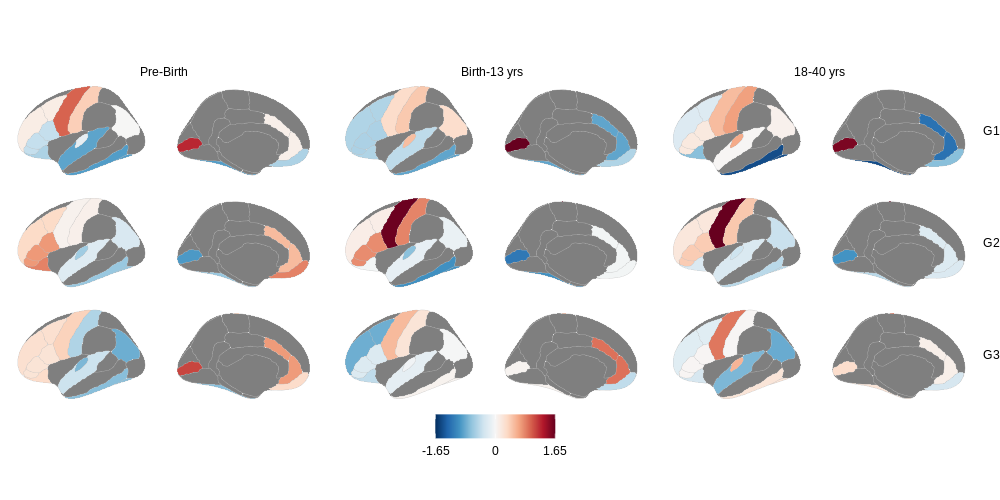

In [457]:
%%R -w 10 -h 5 --units in -r 100 -i bs_scores_grouped_plot
plot_dk(bs_scores_grouped_plot)

## Get disorder maps

In [439]:
maps = get_disorder_maps()#.drop(['ADHD', 'ANX', 'MCI'], axis=1)
maps.head()

,AD,ADHD,ANX,ASD,MCI,MDD,SCZ
label,,,,,,,
lh_bankssts,-1.241970,-0.083818,0.983634,-0.265312,-0.928661,0.389026,0.405498
lh_caudalanteriorcingulate,0.849102,0.851942,1.097002,-1.870202,1.232917,2.660308,1.430681
lh_caudalmiddlefrontal,0.304156,-0.764371,0.303426,-1.538156,0.287226,-0.011789,0.051987
lh_cuneus,1.837609,0.001251,0.303426,0.841510,1.175017,-2.149466,0.829712
lh_entorhinal,-1.964341,0.937011,-0.150046,-1.040086,-2.684942,-0.011789,1.218574


In [440]:
sim_maps = np.load("../outputs/permutations/sim_disorders_dk_5000.npy")

In [460]:
def get_corrs_by_age(maps, bs_scores_grouped_dk, null_maps, which=['AD', 'ASD','MDD','SCZ']):
    ages = bs_scores_grouped_dk['age'].unique()
    maps_mask = np.isin(maps.columns, which)
    null_maps = null_maps[:, maps_mask, :]
    maps = maps.loc[:, maps_mask]
    
    stats = {}
    for age in ages:
        # Select age group
        scores = bs_scores_grouped_dk.set_index(['age', 'label']).loc[age]
        # Change DK labels to ids to match nulls
        scores = get_labels_dk()[:34].to_frame().join(scores, on='label')
        
        corrs = get_corrs(scores, maps, atlas='dk')
        null_corrs = corr_nulls_from_maps(null_maps, scores, maps, method='pearson')
        
        null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh') 
        stats[age] = null_p
    
    stats = pd.concat(stats)
    return stats    

stats = get_corrs_by_age(maps, bs_scores_grouped_dk, sim_maps)

In [442]:
def get_corrs_of_ahba_version(maps, null_maps, version, dk_version=None, 
                              hcp_bs_mapping=None, dk_bs_mapping=None,
                              which=['AD', 'ASD','MDD','SCZ']):
    maps_mask = np.isin(maps.columns, which)
    null_maps_filter = null_maps[:, maps_mask, :]
    maps_filter = maps.loc[:, maps_mask]
    
    if dk_version is not None:
        scores = dk_version.score_from(version)
    elif hcp_bs_mapping is not None:
        scores_mapped = get_mapped_scores(version, hcp_bs_mapping)
        scores_dk = scores_mapped.join(dk_bs_mapping.set_index('structure_name')).set_index('label')
        scores = get_labels_dk()[:34].to_frame().join(scores_dk, on='label')
    elif hcp_bs_mapping is None and dk_bs_mapping is not None:
        scores_mapped = get_mapped_scores(version, dk_bs_mapping)
        scores_dk = scores_mapped.join(dk_bs_mapping.set_index('structure_name')).set_index('label')
        scores = get_labels_dk()[:34].to_frame().join(scores_dk, on='label')
    else:
        scores = version.clean_scores()

        
    corrs = get_corrs(scores, maps_filter, atlas='dk')
    null_corrs = corr_nulls_from_maps(null_maps_filter, scores, maps_filter, method='pearson')
        
    null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh') 
    return null_p  

## DK

In [443]:
null_p = get_corrs_of_ahba_version(maps, sim_maps, version)
null_p_mapped = get_corrs_of_ahba_version(maps, sim_maps, version, 
                                   dk_bs_mapping=dk_bs_mapping)

In [444]:
age_corrs = pd.concat([
    stats.reset_index(0).rename({'level_0':'version'}, axis=1),
    null_p_mapped.assign(version='AHBA-DK mapped to BrainSpan'),
    null_p.assign(version='AHBA-DK')
])

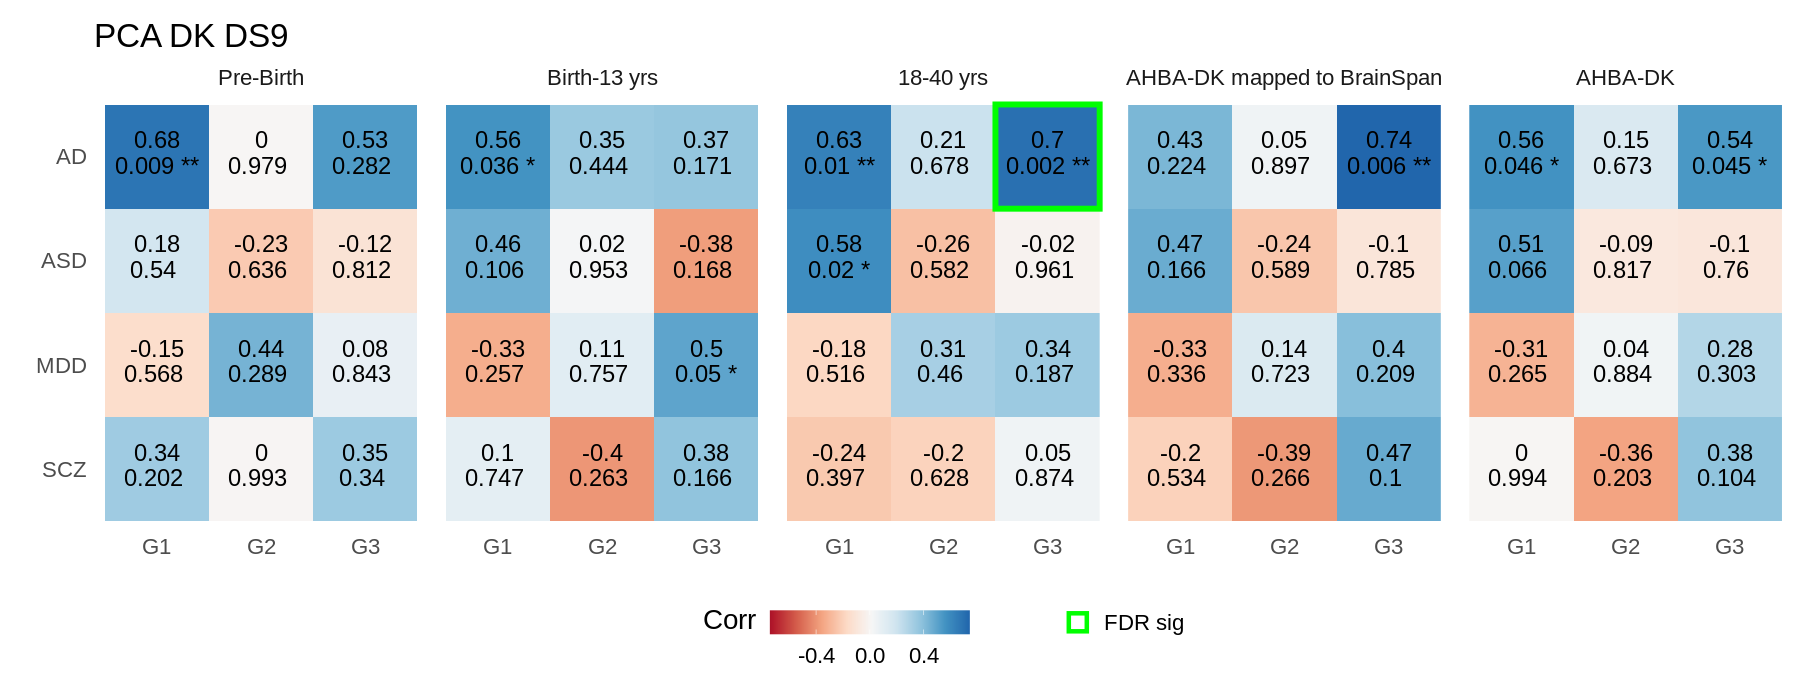

In [449]:
%%R -w 18 -h 7 --units in -r 100 -i age_corrs
source("../code/plot_maps.R")
plot_corr_versions(age_corrs) + ggtitle('PCA DK DS9')

## HCP

In [450]:
hcp_bs_mapping = get_hcp_bs_mapping_v2()

In [453]:
null_p_project = get_corrs_of_ahba_version(maps, sim_maps, version, 
                                   dk_version=pca_dk_ds5)
null_p_mapped = get_corrs_of_ahba_version(maps, sim_maps, version, 
                                   hcp_bs_mapping=hcp_bs_mapping, 
                                   dk_bs_mapping=dk_bs_mapping)

In [461]:
age_corrs = pd.concat([
    stats.reset_index(0).rename({'level_0':'version'}, axis=1),
    null_p_mapped.assign(version='AHBA-HCP mapped to BrainSpan'),
    null_p_project.assign(version='AHBA-HCP projected to DK')
])

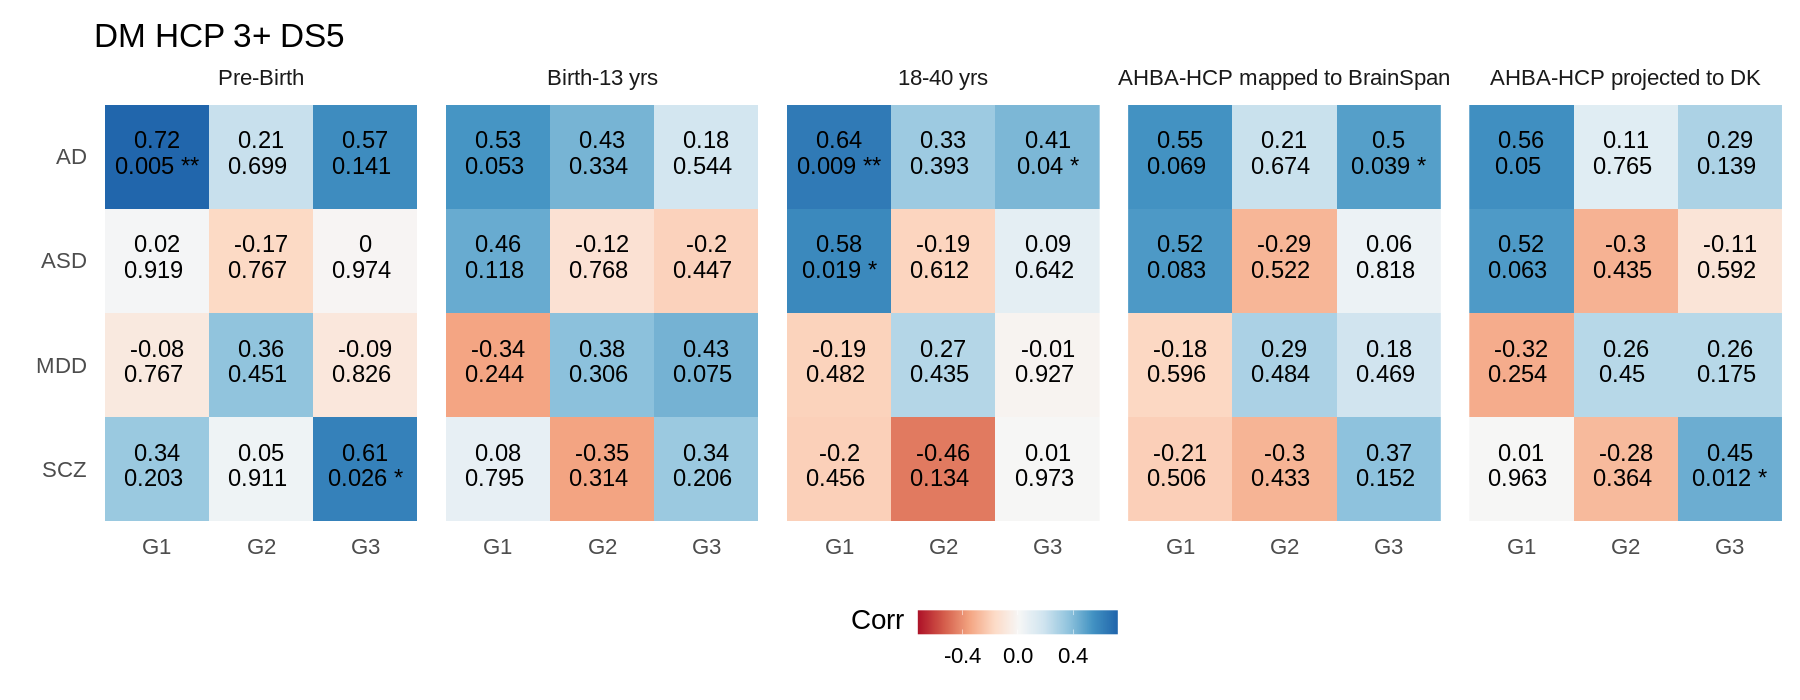

In [462]:
%%R -w 18 -h 7 --units in -r 100 -i age_corrs
source("../code/plot_maps.R")
plot_corr_versions(age_corrs) + ggtitle('DM HCP 3+ DS5')